# Lab 7: Logistic Regression

In this lab, we will manually construct the logistic regression model and minimize cross-entropy loss using `scipy.minimize`. 

In [1]:
# Run this cell to set up your notebook; no further action is needed.
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as py
import plotly.graph_objs as go


%matplotlib inline


<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Data Loading

We will explore a breast cancer dataset from the University of Wisconsin ([source](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic))). This dataset can be loaded using the `sklearn.datasets.load_breast_cancer()` method.  

In [2]:
# Run this cell to load the data; no further action is needed.
data = sklearn.datasets.load_breast_cancer()

# Data is a dictionary.
print(data.keys())
print(data.DESCR)

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 f

<br/>

Since the data format is a dictionary, we will perform some preprocessing to create a `DataFrame`.

In [3]:
# Run this cell to see the first five rows of the data; no further action is needed.
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


The prediction task for this data is to predict whether a tumor is benign or malignant (a binary decision), given the characteristics of that tumor. The prediction labels are stored in the field `data.target`. To put the data back in its original context, we will create a new column called `"malignant"` which will be 1 if the tumor is malignant and 0 if it is benign (reversing the definition of `target`).

In this lab, we will fit a simple **classification model** to predict breast cancer from the cell nuclei of a breast mass. For simplicity, we will work with only one feature: the `mean radius` which corresponds to the size of the tumor. Our output (i.e., response) is the `malignant` column.

In [4]:
# Run this cell to define X and Y; no further action is needed.

# Target data_dict['target'] = 0 is malignant 1 is benign
df['malignant'] = (data.target == 0).astype(int)

# Define our features/design matrix X
X = df[["mean radius"]]
Y = df['malignant']

<br/>

Before we go further, we will split our dataset into training and testing sets. This lets us explore the prediction power of our trained classifier on both seen and unseen data.

In [5]:
# Run this cell to create a 75-25 train-test split; no further action is needed. 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
print(f"Training Data Size: {len(X_train)}")
print(f"Test Data Size: {len(X_test)}")

Training Data Size: 426
Test Data Size: 143


<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 1: Defining the Model

In these first two parts, you will manually build a logistic regression classifier.

Recall that the Logistic Regression model is written as follows:

$$p = \Large f_{\theta}(x) = \sigma ( x^T \theta)$$

where $f_{\theta}(x)= P(Y=1 | x)$ is the probability that our observation belongs to class 1, and $\sigma$ is the sigmoid activation function:

$$\Large \sigma(z) = \frac{1}{1 + e^{-z}}$$

If we have a single feature, then $x$ is a scalar and our model has parameters $\theta^T = [\theta_0 \ \ \theta_1]$ as follows:

$$\Large f_{\theta}(x) = \sigma (\theta_0 + \theta_1 x)$$

Therefore just like OLS, if we have $n$ data points and $d$ features, then we can construct the design matrix
$$\Large \mathbb{X} \in \mathbb{R}^{n \times (d + 1)}$$
with an all-ones column. Run the below cell to construct `X_intercept_train`. The syntax should look familiar:

In [6]:
# Run this cell to add the bias column; no further action is needed.
def add_bias_column(X):
    return np.hstack([np.ones((len(X), 1)), X])

X_intercept_train = add_bias_column(X_train)
X_intercept_train.shape

(426, 2)

<br/>

---

### Question 1a

Using the above definition for $\mathbb{X}$, we can also construct a matrix representation of our Logistic Regression model, just like we did for OLS. Noting that $\theta^T = [\theta_0 \ \ \theta_1\ \ \dots \ \ \theta_d$], the vector $\hat{\mathbb{Y}}$ is:

$$\Large \hat{\mathbb{Y}} = \sigma(\mathbb{X} \theta) $$

Then the $i$-th element of $\hat{\mathbb{Y}}$ is the probability that the $i$-th observation belongs to class 1, given the feature vector is the $i$-th row of design matrix $\mathbb{X}$, and the parameter vector $\theta$.

Below, implement the `lr_model` function to evaluate this expression. To matrix-multiply two `numpy` arrays, use `@` or `np.dot`. In case you're interested, the [matmul documentation](https://numpy.org/devdocs/reference/generated/numpy.matmul.html) contrasts the two methods.



In [7]:
def sigmoid(z):
    """
    The sigmoid function 
    """
    return 1/(1 + np.exp(-z))

def lr_model(theta, X):
    """
    Returns the logistic regression model as defined above.
    You should not need to use a for loop; use @ or np.dot.
    
    Args:
        theta: The model parameters. Dimension (d+1,).
        X: The design matrix. Dimension (n, d+1).
    
    Return:
        Probabilities that Y = 1 for each data point.
        Dimension (n,).
    """
    return sigmoid(X @ theta)

<br/>

---

###  Question 1b: Compute Empirical Risk
Now let's try to analyze the cross-entropy loss from logistic regression. Suppose for a single observation, we predict probability $p$ that the true response $y$ is in class 1 (otherwise the prediction is 0 with probability $1 - p$). The cross-entropy loss is $-log(p)$ when $y=1$ and $-log(1-p)$ when $y=0$. More concretely:

$$ \text{CE Loss} = - \left( y \log(p) + (1 - y) \log(1 - p) \right)$$

For the logistic regression model, the **empirical risk** is therefore defined as the average cross-entropy loss across all $n$ data points:

$$R(\theta) = -\frac{1}{n} \sum_{i=1}^n \left( y_i \log(\sigma(X_i^T \theta)) + (1 - y_i) \log(1 - \sigma(X_i^T \theta))  \right) $$

Where $y_i$ is the $i$ th response in our dataset, $\theta$ are the parameters of our model, $X_i^T$ is the $i$-th row of our design matrix $\mathbb{X}$, and $\sigma(X_i^T \theta)$ is the probability that the response is 1 given input $X_i$.

Below, implement the function `lr_loss` that computes empirical risk over the dataset. Feel free to use the functions defined in the previous part.

In [9]:
def lr_avg_loss(theta, X, Y):
    '''
    Compute the average cross-entropy loss using X, Y, and theta.
    You should not need to use a for loop. 

    Args:
        theta: The model parameters. Dimension (d+1,).
        X: The design matrix. Dimension (n, d+1).
        Y: The label. Dimension (n,).

    Return:
        The average cross-entropy loss.
    '''
    ce_loss = -Y * np.log(lr_model(theta, X)) - (1 - Y) * np.log(1 - lr_model(theta, X))
    return np.mean(ce_loss)

<br/>

Below is an interactive plot showing the average training cross-entropy loss for various values of $\theta_0$ and $\theta_1$ (respectively x and y axis in the plot). You may receive a `Javascript Error: Something went wrong with axis scaling` error. If your image does not show up, there are two potential workarounds: (1) run the following cell below to generate a static version of the plot and check out the interactive plot (2) restart your kernel (upper left menu -> `Kernel` -> `Restart Kernel and Run up to Selected Cell...`). 

In [10]:
# Run this cell to create the plotly visualization. 
# If this gives a  Javascript Error, run the cell below instead. 
with np.errstate(invalid='ignore', divide='ignore'):
    uvalues = np.linspace(-8,8,70)
    vvalues = np.linspace(-5,5,70)
    (u,v) = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))
    lr_avg_loss_values = np.array([lr_avg_loss(t, X_intercept_train, Y_train) for t in thetas.T])
    lr_loss_surface = go.Surface(name="Logistic Regression Loss",
            x=u, y=v, z=np.reshape(lr_avg_loss_values,(len(uvalues), len(vvalues))),
            contours=dict(z=dict(show=True, color="gray", project=dict(z=True)))
        )
    fig = go.Figure(data=[lr_loss_surface])
    fig.update_layout(
        scene = dict(
            xaxis_title='theta_0',
            yaxis_title='theta_1',
            zaxis_title='Loss'),
            width=700,
            margin=dict(r=20, l=10, b=10, t=10))
    py.iplot(fig)

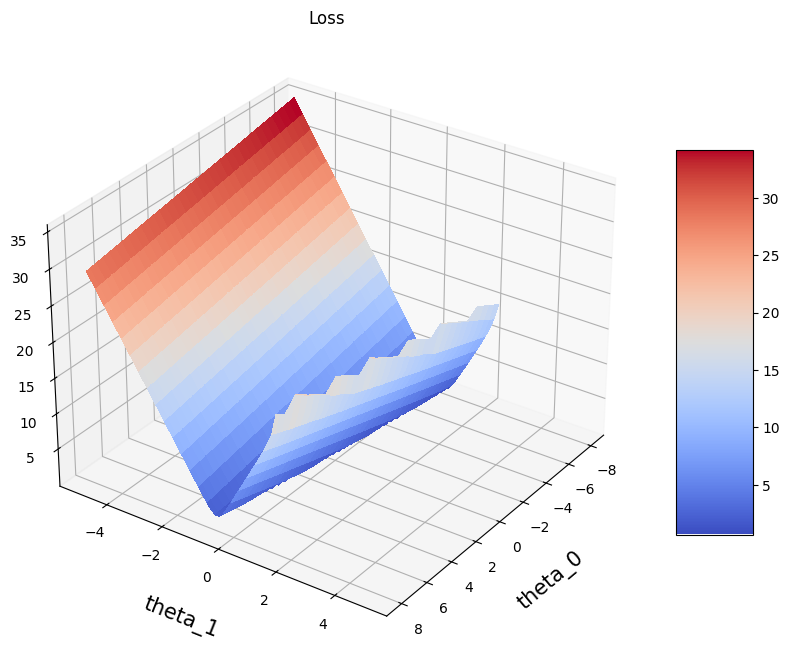

In [11]:
# Run this cell to create the plotly visualization; no further action is required. 
from matplotlib import cm

with np.errstate(invalid='ignore', divide='ignore'):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
    
    uvalues = np.linspace(-8,8,70)
    vvalues = np.linspace(-5,5,70)
    u,v = np.meshgrid(uvalues, vvalues)
    thetas = np.vstack((u.flatten(),v.flatten()))
    lr_avg_loss_values = np.array([lr_avg_loss(t, X_intercept_train, Y_train) for t in thetas.T])


    # Plot the surface.
    surf = ax.plot_surface(u, v, np.reshape(lr_avg_loss_values,(len(uvalues), len(vvalues))), 
                           cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Set the azimuth and elevation angles
    ax.view_init(azim=35, elev=30)
    
    # customize 
    plt.xlabel('theta_0', fontsize=15, labelpad=15)
    plt.ylabel('theta_1', fontsize=15, labelpad=15)
    plt.title('Loss')
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    

<!-- BEGIN QUESTION -->

<br/>

---

### Question 1c
Describe one interesting observation about the loss plot above.


We can see that as theta_1 increases towards 0, the loss decreases and subsequently once
past a treshold, the loss starts to increase again. Thus, we can say that there is a value of
theta_1 that we can find that minimises the loss.
Looking at theta_0, we see that the impact on the loss is not as huge compared to theta_1
but we can see that in this dimension, it does reduce the loss. We can now say that
theta_0 also impacts the loss function, and there exist some value of theta_1 and theta_0
that minimises the loss.

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 2: Fit and Predict

### `scipy.optimize.minimize`

The next two cells call the `minimize` function from `scipy` on the `lr_avg_loss` function you defined in the previous part. We pass in the training data to `args` ([documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)) to find the `theta_hat` that minimizes the average cross-entropy loss over the training set.

In [12]:
# Run this cell to minimize lr_avg_loss using scipy; no further action is needed.
from scipy.optimize import minimize

min_result = minimize(lr_avg_loss,
                      x0=np.zeros(X_intercept_train.shape[1]),
                      args=(X_intercept_train, Y_train))
min_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.3123767645012733
        x: [-1.387e+01  9.372e-01]
      nit: 16
      jac: [-4.061e-07 -7.331e-06]
 hess_inv: [[ 7.479e+02 -5.213e+01]
            [-5.213e+01  3.684e+00]]
     nfev: 57
     njev: 19

In [13]:
# Run this cell to print `theta_hat`; no further action is needed.
theta_hat = min_result['x']
theta_hat

array([-13.87178312,   0.93723893])

<br/>

Because our design matrix $\mathbb{X}$ leads with a column of all ones, `theta_hat` has two elements: $\hat{\theta}_0$ is the estimate of the intercept/bias term, and $\hat{\theta}_1$ is the estimate of the slope of our single feature.

<br/>


The main takeaway is that logistic regression models **probabilities** of classifying data points as 1 or 0. Next, we use this takeaway to implement model predictions.

<br/>

---

## Question 2

Using the `theta_hat` estimate above, we can construct a **decision rule** for classifying a data point with observation $x$. Let $P(Y = 1 | x) = \sigma(x^T \hat{\theta})$:

$$ \text{classify}(x) = \begin{cases} 
1, &\quad\text{if}\ \  P(Y = 1 | x) \geq 0.5 \\ 
0, &\quad\text{if}\ \ P(Y = 1 | x) < 0.5 
\end{cases}$$

This decision rule has a decision **threshold** $T = 0.5$. This threshold means that we treat the classes $0$ and $1$ "equally." Lower thresholds mean that we are more likely to predict $1$, whereas higher thresholds mean that we are more likely to predict $0$.

<br/>

Implement the `lr_predict` function below, which returns a vector of predictions according to the logistic regression model. The function  takes a design matrix of observations `X`, parameter estimate `theta`, and decision threshold `threshold` with a default value of 0.5.

In [15]:
def lr_predict(theta, X, threshold=0.5):
    '''
    Classification using a logistic regression model
    with a given decision rule threshold.

    Args:
        theta: The model parameters. Dimension (d+1,)
        X: The design matrix. Dimension (n, d+1).
        threshold: Decision rule threshold for predicting class 1.

    Return:
        A vector of predictions.
    '''
    return np.where(lr_model(theta, X) > threshold, 1, 0)

# Do not modify below this line.
Y_train_pred = lr_predict(theta_hat, X_intercept_train)
Y_train_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,

<br/>

### Linearly separable data

How do these predicted classifications compare to the true responses $\mathbb{Y}$?

Run the cell below to visualize our predicted responses, the true responses, and the probabilities we used to make predictions. We use `sns.stripplot` which introduces some jitter to avoid overplotting.

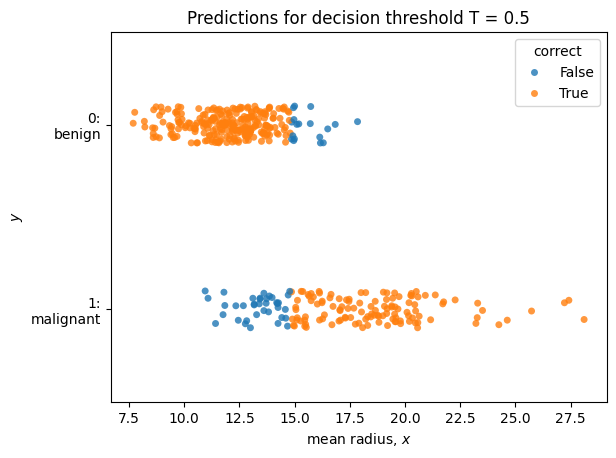

In [16]:
# Run this cell to generate the visualization; no further action is needed.
plot_df = pd.DataFrame({"X": np.squeeze(X_train),
                        "Y": Y_train,
                        "Y_pred": Y_train_pred,
                        "correct": (Y_train == Y_train_pred)})
sns.stripplot(data=plot_df, x="X", y="Y", orient='h', alpha=0.8, hue="correct")
plt.xlabel('mean radius, $x$')
plt.ylabel('$y$')
plt.yticks(ticks=[0, 1], labels=['0:\nbenign', '1:\nmalignant'])
plt.title("Predictions for decision threshold T = 0.5")
plt.show()

<br/>
<hr style="border: 1px solid #fdb515;" />

# Part 3: Quantifying Performance



### sklearn's `LogisticRegression`
Instead of using the model structure that we built manually in the previous questions, we will instead use `sklearn`'s `LogisticRegression` function, which operates similarly to the `sklearn` OLS, Ridge, and LASSO models.

Let's first fit a logistic regression model to the training data. Some notes: 
* Like with linear models, the `fit_intercept` argument specifies if the model includes an intercept term. We therefore pass in the original matrix `X_train` (defined at the beginning of the notebook, without intercept term) in the call to `lr.fit()`.
* `sklearn` fits an **L2 regularized** logistic regression model by default as specified in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for more details. The `penalty` argument specifies the regularization penalty term. 

In [17]:
# Run this cell to fit a sklearn LogisticRegression model; no further action is needed. 
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
        fit_intercept=True,
        penalty='l2')

lr.fit(X_train, Y_train)
lr.intercept_, lr.coef_

(array([-13.75518968]), array([[0.92897696]]))

<br/>

Note that because we are now fitting a regularized logistic regression model, the estimated coefficients above deviate slightly from our numerical findings in Question 1.

<br/>

Like with linear models, we can call `lr.predict(x_train)` to classify our training data with our fitted model.

In [18]:
# Run this cell to make predictions; no further action is needed. 
lr.predict(X_train)

array([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,

Note that for a binary classification task, the `sklearn` model uses an unadjustable decision rule of 0.5. If you're interested in manually adjusting this threshold, check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for `lr.predict_proba()`.

<br/>

---

### Question 3a: Accuracy

Fill in the code below to compute the training and testing accuracy, defined as:

$$
\text{Training Accuracy} = \frac{1}{n_{train\_set}} \sum_{i \in {train\_set}} {\mathbb{1}_{y_i = \hat{y_i}}}
$$

$$
\text{Testing Accuracy} = \frac{1}{n_{test\_set}} \sum_{i \in {test\_set}} {\mathbb{1}_{y_i = \hat{y_i}}}
$$

where for the $i$-th observation in the respective dataset, $\hat{y_i}$ is the predicted response (class 0 or 1), and $y_i$ is the true response.  $\mathbb{1}_{y_i = \hat{y_i}}$ is an indicator function which is $1$ if ${y_i} = \hat{y_i}$ and $ 0$ otherwise.

In [19]:
train_accuracy = lr.score(X_train, Y_train)
test_accuracy = lr.score(X_test, Y_test)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.8709
Test accuracy: 0.9091


<br/>

---

### Question 3b: Precision and Recall

It seems we can get a very high test accuracy. What about precision and recall?  
- **Precision** (also called positive predictive value) is the fraction of true positives among the total number of data points predicted as positive.  
- **Recall** (also known as sensitivity) is the fraction of true positives among the total number of data points with positive labels.

Precision measures the ability of our classifier to avoid predicting negative samples as positive (i.e., avoid false positives), while recall is the ability of the classifier to find all the positive samples (i.e., avoid false negatives).

Below is a graphical illustration of precision and recall, modified slightly from [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall):

<img src="precision_recall.png" alt="precision_recall" width="600">

Mathematically, Precision and Recall are defined as:
$$
\text{Precision} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_positives}} = \frac{TP}{TP+FP}
$$

$$
\text{Recall} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_negatives}}=\frac{TP}{TP+FN}
$$

Use the formulas above to compute the precision and recall for the **test set** using the `lr` model trained using `sklearn`.

In [21]:
Y_test_pred = lr.predict(X_test)

precision = np.sum((Y_test == 1) & (Y_test_pred == 1)) / ( np.sum((Y_test == 1) & (Y_test_pred == 1)) + np.sum((Y_test == 0) & (Y_test_pred == 1)) )
recall = np.sum((Y_test == 1) & (Y_test_pred == 1)) / ( np.sum((Y_test == 1) & (Y_test_pred == 1)) + np.sum((Y_test == 1) & (Y_test_pred == 0)) )

print(f'precision = {precision:.4f}')
print(f'recall = {recall:.4f}')

precision = 0.9184
recall = 0.8333


<!-- BEGIN QUESTION -->

<br>

---

### Question 3c
Based on the above distribution, what might explain the observed difference between our precision and recall metrics?

We can observe that the numerator for the both values are the same, and the
difference lies in the denominator. Through looking at the denomiator
we find that the recall is lower than precision, suggesting that the
False Negatives in the model is higher than that of the False Positives. We can
say that on average the model is able to classify the items in the correct class
but it is not as well versed in obtaining all the relevant items in the positive
set.

<!-- END QUESTION -->

<br/>


### Confusion Matrices

To understand the link between precision and recall, it's useful to create a **confusion matrix** of our predictions. Luckily, `sklearn.metrics` provides us with such a function!

The `confusion_matrix` function ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)) categorizes counts of data points based if their true and predicted values match.

For the 143-datapoint test dataset:

In [22]:
# Run this cell to define the confusion matrix; no further action is needed.
from sklearn.metrics import confusion_matrix

Y_test_pred = lr.predict(X_test)
cnf_matrix = confusion_matrix(Y_test, Y_test_pred)
cnf_matrix

array([[85,  4],
       [ 9, 45]])

We've implemented the following function to better visualize these four counts against the true and predicted categories:

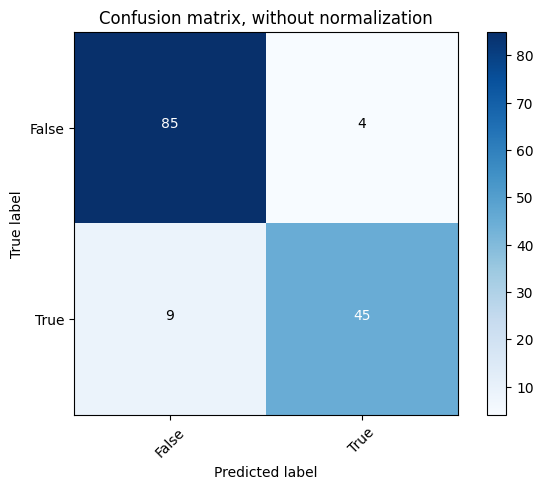

In [23]:
# Run this cell to plot the confusion matrix; no further action is needed.

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['False', 'True']

plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

<br>

---

### Question 3d: Normalized Confusion Matrix

To better interpret these counts, assign `cnf_matrix_norm` to a **normalized confusion matrix** by the count of each true label category.

In other words, build a 2-D `numpy` array constructed by normalizing `cnf_matrix` by the count of data points in each row. For example, the top-left quadrant of `cnf_matrix_norm` should represent the proportion of true negatives over the total number of data points with negative labels. 

**Hints**: 
* When adding values in a 2-D array `arr`, `arr.sum(axis=0)` will calculate the sum of the columns while `arr.sum(axis=1)` will calculate the sum of the rows. 
* In array broadcasting, you may encounter issues dividing 2-D `numpy` arrays by 1-D `numpy` arrays. 
    * Check out the `keepdims` parameter in `np.sum` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.sum.html)), to preserve the dimensions of `cnf_matrix` after using `np.sum` on it.
    * Alternatively, add the dimension back using `np.newaxis` ([documentation](https://numpy.org/doc/stable/reference/constants.html#numpy.newaxis)).

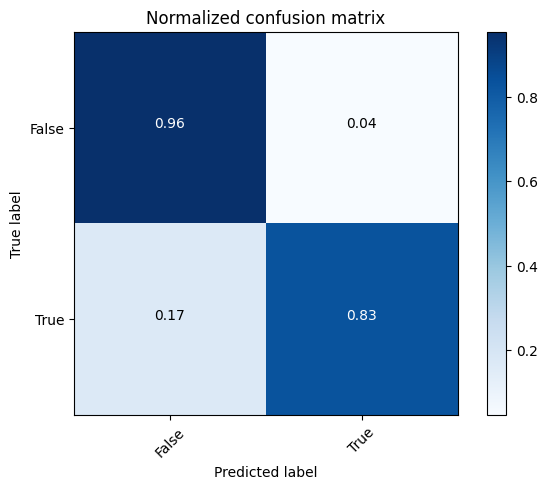

In [24]:
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

# Do not modify below this line.
plot_confusion_matrix(cnf_matrix_norm, classes=class_names,
                       title='Normalized confusion matrix')

## Submission

Make sure you have run all cells in your notebook in order, so that all images/graphs appear in the output. 